<a href="https://colab.research.google.com/github/ronald-hk-chung/ssnotebook/blob/main/computer_vision/resnet_cifar100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building ResNet to train on Cifar100

**Mission Statement**

1. Building a ResNet from scratch
2. Train ResNet on Cifar-100 Dataset

## Notebook Preperation

In [1]:
!pip install -q git+https://github.com/ronald-hk-chung/sstorch.git

from sstorch.learner import SSTLearner
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchinfo

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


## Introduction to ResNet

**Motivation**

ResNets were introduced in 2015 by Kaiming He et al. in their paper [Deep Residual Learning from Image Recognition](https://arxiv.org/abs/1512.03385). Since its introduction, it has become a staple in the deep learning community, often serving as a starting point for many image classification tasks.

In 2015, neural network depth and its related performance were a key area of interest. A general observation at that time was stacking more and more similar layers on top of each other to create larger networks resulted in models that performed no better than their smaller counterparts. More interestingly, the difference was observed not only in teh validation set but also in the training set. In other words, this wasn't just a generalization issue but a training issue.

In theory, there are always deep networks that should be at least as good as any shallow network. But author of the paper observed degradation problem using stochastic gradient descent (SGD) - vanishing gradient problem.

As quoted in the original paper,

*When deeper networks are able to start converging, a degradation problem has been exposed: with the network depth increasing, accuracy gets saturated (which might be unsurprising) and then degrades rapidly. Unexpectedly, such degradation is not caused by overfitting, and adding more layers to a suitably deep model leads to higher training error, verified by our experiments.*

When training neural networks with gradient-based learning methods and backpropagation, each of the neural network's weights receives an update proportional to the gradient of the error function with respect to the current weight in each iteration of training.

The problem is that, in some cases, the gradient will be vanishingly small, effectively preventing the weight from changing its value. In the worst case, this may completely stop the neural network from further training.

As the backpropagation algorithm computes gradients using the chain rule, this has the effect of multiplying n of these small numbers to compute gradients of the "front" layers in an n-layer network, meaning that the gradient (error signal) decreases exponentially with n while the front layers train very slowly.

<br/>

**Solution**

In order to counter this, ResNets were proposed which consisted mainly of the Residual Blocks. These blocks consisted of skip connections which added the input x back to the output of the block, which effectively gave us the result $h(x) = f(x) + x$ at the end of the block.

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/residual_blocks.png?raw=true">

The input x is passed throuh the layers and activations to get hte output $F(x)$, where the input x is added back to the output. This processof adding the input into the a block back to its output is called a **skip connection** or **shortcut**. The weight layers of the blok learn to output $F(x) = h(x) - x$ which is called a Residual. Since the network optimizes the solver to adjust the weight layers based on teh residual after each block, the network is called Residual network **(ResNet)**

## ResNet Architecture

The commonly used ResNet architectures include ResNet-18, ResNet-34, ResNet-50, ResNet-101 and ResNet-152, each of which has different residual block structure and different number of residual blocks

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/resnet_architecture.png?raw=true">

Each of 5 ResNet architecture consists of 5 convsolutional layers (conv1, conv2_x to conv5_x), an average pooling layer, a fully connected layer and softmax.

Each convsolutional layers from conv2_x to conv5_x uses different number of the residual blocks. e.g. in ResNet-18, the number of residual blocks used in conv2_x, conv_3_x, conv4_x and conv5_x is 2, 2, 2, 2 respectively.

Note that the structure fo the residual block used by ResNet-18 and ResNet-34 is different from the one used by ResNet-50, ResNet-101 and ResNet-152 with 2 different implimentation of residual blocks.

There are 2 types of ResNet blocks:

* Basic Blocks
* BottleNeck Blocks

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/basicblock_and_bottleneck.png?raw=true">

ResNet-18 and ResNet34 uses **BasicBlock** but starting from ResNet-50, the **BottleNeck** structure is used to reduce model parameters by alternating 1x1 and 3x3 convsolutions, compared to two convolutions of 3x3, 64 and 3x3, 256, the number of model parameters are reduced from 294912 to 69632. Another advantage of the bottleneck structure is that more activations are introduced due to more convolutions which increases nonlinearity and model capacity.



## Implimentation of Basic Blocks

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/basicblock.png?raw=true">

Note that we set the expansion factor to 1 as there is no expansion of channels being performed in the BasicBlock. In cases where the stride of the convolution is more than 1, it wil cause the shape of the input $x$ and output $f(x)$ from the block to be mis-matched, which prevent the addition. Therefore, a downsample option is required to be performed before the addition for the shape to match

In [2]:
from typing import Any, Callable, List, Optional, Type, Union

import torch
from torch import Tensor
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(self,
                 inplanes: int,
                 planes: int,
                 stride: int = 1,
                 downsample: Optional[nn.Module] = None):
        """BasicBlock Class for ResNet-18 and ResNet-34

        Args:
            inplanes (int): num of input dimensions of BasicBlock
            planes (int): num of output dimensions of BasicBlock
            stride (int): stride use in first 3x3 convolutional layer
            downsample (nn.Module): downsample input identity in case stride!=1 for the shape to match
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=inplanes,
                               out_channels=planes,
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=planes,
                               out_channels=planes,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=planes)
        self.downsample = downsample

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

## Implimentation of BlotteNeck

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/bottleneck.png?raw=true">

In order to train deeper nets on the ImageNet dataset, Resnet-50 onwards modified the building block as a **BottleNeck** design which can reduce training time. In the **BottleNeck**, stack of 3 layers instead of 2 are used. The first 1x1 is used to reduce the dimensions leaving the 3x3 layer a bottleneck with smaller input and output dimension(256 to 64). Then, 1x1 is used again to increase the dimension(64 to 256). As a result, A bottleneck layer is a layer that contains few nodes compared to the previous layers. It can be used to obtain a representation of the input with reduced dimensionality. For the last 1x1 Convolution, the width that get increased by a factor of 4 to 256, therefore expansion factor is set to 4



In [3]:
class Bottleneck(nn.Module):
    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None):
        """Bottneck for ResNet-50, ResNet-101 and ResNet-152

        Args:
            inplanes (int): num of input dimensions of Botteneck
            planes (int): num of output dimensions for intermediate first 1x1 and second 3x3 convolution
            stride (int): stride use in 3x3 convolutional layer
            downsample (nn.Module): downsample input identity in case stride!=1 for the shape to match
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=inplanes,
                               out_channels=planes,
                               kernel_size=1,
                               stride=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=planes)
        self.conv2 = nn.Conv2d(in_channels=planes,
                               out_channels=planes,
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=planes)
        self.conv3 = nn.Conv2d(in_channels=planes,
                               out_channels=planes * self.expansion,
                               kernel_size=1,
                               stride=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

## Building the ResNet

The final ResNet class implimentation takes input for the blocktype and the number of blocks required to be created. This is achieved by *_make_layer* function which creates these layers and downsamples the input tensor of the first block if applicable.

Before the ResNet blocks are created, there is a *resnet stem* which consists of a Convolutional Block followed by an activation layer. A convolutional block typically consists of a convolutional layer, a normalization layer and a pooling layer. A stem is used because layers/blocks with more parameters such as ResNet blocks have to perform more computations, which makes the network slower on large feature maps (feature maps get smaller as the image progresses through the network). However, majority of the computations happen in the earlier layers of the network and using a compute heavy block will slow down the network training. Therefore, using a stem (with large kernel size and stride) to quickly downsample the image will help speed up the training of the neural network.

In [4]:
class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000):
        """Simplified ResNet Implimentation

        Args:
            block (nn.Module): residual block type
            layers (list[int]): num of esidual blocks for each conv layer
            num_classes: number of classes for image classification, Default 1000

        Reference for ResNet Architecture
        ResNet-18: ResNet(BasicBlock, [2, 2, 2, 2], 1000)
        ResNet-34: ResNet(BasicBlock, [3, 4, 6, 3], 1000)
        ResNet-50: ResNet(Bottleneck, [3, 4, 6, 3], 1000)
        ResNet-101: ResNet(Bottleneck, [3, 4, 23, 3], 1000)
        ResNet-152: ResNet(Bottleneck, [3, 8, 36, 3], 1000)
        """
        super().__init__()

        # Resnet stem to downsample image to speed up training
        self.inplanes = 64
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=self.inplanes,
                               kernel_size=7,
                               stride=2,
                               padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3,
                                    stride=2,
                                    padding=1)

        # Residual Blocks conv2_x to conv5_x
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Weight initialization using kaiming_normal
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1):

        # downsample for identity with same stride if stride!=1
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels=self.inplanes,
                          out_channels=planes * block.expansion,
                          kernel_size=1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm2d(num_features=planes * block.expansion),
            )
        # initiailise layer
        # append first layer with downsample with same stride if stride!=1
        layers = []
        layers.append(block(inplanes=self.inplanes,
                            planes=planes,
                            stride=stride,
                            downsample=downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(inplanes=self.inplanes,
                                planes=planes))

        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

## Prepare Cifar100 Dataset and DataLoader

In [5]:
import torchvision
from torchvision.datasets import CIFAR100
import torchvision.transforms as T
from torch.utils.data import DataLoader

train_ds = CIFAR100(root='data',
                    train=True,
                    download=True)

valid_ds = CIFAR100(root='data',
                    train=False,
                    download=True)

# To get the mean and standard deviations of cifar10
data_shape = train_ds.data.shape
data_mean = train_ds.data.mean(axis=(0, 1, 2))/255
data_std = train_ds.data.std(axis=(0, 1, 2))/255

# Define transforms from PIL to Tensors
tfms = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize(mean=data_mean,
                std=data_std)
])

# Define transforms from PIL to Tensors with Data Augmentation
tfms_augmented = T.Compose([
    T.Resize(size=(224, 224)),
    T.TrivialAugmentWide(num_magnitude_bins=10),
    T.ToTensor(),
    T.Normalize(mean=data_mean,
                std=data_std)
])

# Define reverse transforms from Tensors to PIL (for visualisation)
rtfms = T.Compose([
    T.Normalize(mean=[0.0] * 3,
                std=list(map(lambda x: 1 / x, data_std))),
    T.Normalize(mean=list(map(lambda x: -x, data_mean)),
                std=[1.0] * 3),
    T.ToPILImage()
])

# Apply transforms to dataset
train_ds = CIFAR100(root='data',
                    train=True,
                    transform=tfms_augmented,
                    download=True)

valid_ds = CIFAR100(root='data',
                    train=False,
                    transform=tfms,
                    download=True)


# Create DataLoader for train/valid dataset
train_dl = DataLoader(dataset=train_ds,
                      batch_size=128,
                      shuffle=True)

valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=128,
                      shuffle=False)

100%|██████████| 169001437/169001437 [00:12<00:00, 13140116.30it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Prepare for Model Training

In [6]:
import torch.nn as nn
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from sstorch.vision.cifar100 import superclass_labels

# Define loss_fn
loss_fn = nn.CrossEntropyLoss()

# Define metric_fn that returns dictionary of accuracy, top_5_accuracy and accuracy_super
def metric_fn(y_logits, y):
    # Get Probs and Probabilities using softmax and argmax
    y_probs = y_logits.softmax(dim=-1).detach().cpu().numpy()
    y_preds = y_probs.argmax(axis=-1)
    y = y.detach().cpu().numpy()

    # Transform to superclass labels
    y_preds_super = superclass_labels[y_preds]
    y_super = superclass_labels[y]

    accuracy = accuracy_score(y, y_preds)
    top_5_accuracy = top_k_accuracy_score(y, y_probs, k=5, labels=list(range(100)))
    accuracy_super = accuracy_score(y_super, y_preds_super)
    return {'accuracy': accuracy,
            'top_5_accuracy': top_5_accuracy,
            'accuracy_super': accuracy_super}

# Initialise model using ResNet-50 architecture
model = ResNet(Bottleneck, [3, 4, 6, 3], 100)

# Define optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=3e-4)

learner = SSTLearner(model=model,
                     loss_fn=loss_fn,
                     metric_fn=metric_fn,
                     optimizer=optimizer,
                     train_dataloader=train_dl,
                     valid_dataloader=valid_dl)

In [7]:
learner.model_info()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [128, 3, 224, 224]   [128, 100]           --                   True
├─Conv2d (conv1)                         [128, 3, 224, 224]   [128, 64, 112, 112]  9,408                True
├─BatchNorm2d (bn1)                      [128, 64, 112, 112]  [128, 64, 112, 112]  128                  True
├─ReLU (relu)                            [128, 64, 112, 112]  [128, 64, 112, 112]  --                   --
├─MaxPool2d (maxpool)                    [128, 64, 112, 112]  [128, 64, 56, 56]    --                   --
├─Sequential (layer1)                    [128, 64, 56, 56]    [128, 256, 56, 56]   --                   True
│    └─Bottleneck (0)                    [128, 64, 56, 56]    [128, 256, 56, 56]   --                   True
│    │    └─Conv2d (conv1)               [128, 64, 56, 56]    [128, 64, 56, 56]    4,096                True
│    │    └─BatchN

  0%|          | 0/100 [00:00<?, ?it/s]

Max Gradient: 1.36E-03 | Lowest Loss: 2.87E-04


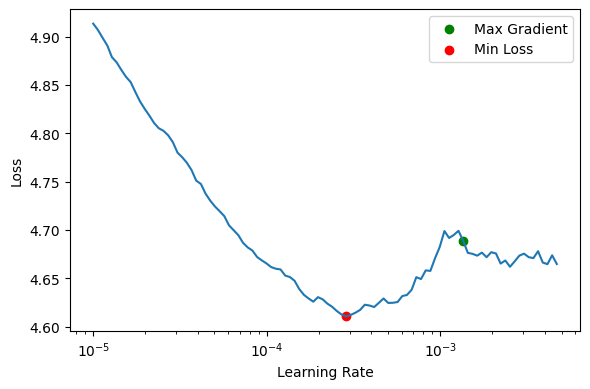

In [8]:
learner.lr_range_test(end_lr=5e-3, start_lr=1e-5)

In [9]:
learner.train(30)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | LR: 3.0E-04 | train_loss: 4.148 | valid_loss: 3.659 
train_metric: {'accuracy': 0.072, 'top_5_accuracy': 0.24, 'accuracy_super': 0.17}
valid_metric: {'accuracy': 0.132, 'top_5_accuracy': 0.374, 'accuracy_super': 0.256}
----------------------------------------------------------------------------------------------------
Epoch: 2 | LR: 3.0E-04 | train_loss: 3.625 | valid_loss: 3.306 
train_metric: {'accuracy': 0.151, 'top_5_accuracy': 0.394, 'accuracy_super': 0.277}
valid_metric: {'accuracy': 0.203, 'top_5_accuracy': 0.477, 'accuracy_super': 0.348}
----------------------------------------------------------------------------------------------------
Epoch: 3 | LR: 3.0E-04 | train_loss: 3.176 | valid_loss: 2.807 
train_metric: {'accuracy': 0.225, 'top_5_accuracy': 0.512, 'accuracy_super': 0.365}
valid_metric: {'accuracy': 0.292, 'top_5_accuracy': 0.611, 'accuracy_super': 0.441}
----------------------------------------------------------------------------------------------------
Epo

## Cifar-100 Leaderboard

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/computer_vision/assets/cifar100_leaderboard_noextra.png?raw=true">

## Comparing VGG to ResNet

**VGG (Visual Geometry Group)**

*   **Architecture:** VGG, specifically VGG16 and VGG19, are known for their deep architectures with 16 and 19 layers respectively. They use small (3x3) convolution filters throughout and increase depth by stacking more layers.

*   **Simplicity:** The architecture is uniform and simple, which makes it easy to understand and implement.

*   **Parameter Size:** VGG models are quite large in terms of the number of parameters, primarily due to fully connected layers, which makes them memory intensive.

*   **Feature Extraction:** VGG models are good at learning hierarchies of features, making them suitable for tasks where fine-grained features are important.

*   **Transfer Learning Use:** Often used as a feature extractor in transfer learning. The pre-trained VGG models can be used to extract features, which can then be used for various classification tasks.

<br/>

**ResNet (Residual Networks)**

*   **Architecture:** ResNet comes in various depths (ResNet-18, ResNet-34, ResNet-50, ResNet-101, and ResNet-152). Its key innovation is the use of residual connections, which allow the gradient to flow through the network more effectively by using skip connections.

*   **Handling Vanishing Gradients:** The residual blocks effectively address the vanishing gradient problem, allowing training of very deep networks.

*   **Parameter Efficiency:** Despite being deeper, ResNets are more parameter-efficient compared to VGG due to the usage of global average pooling instead of fully connected layers at the end, and due to the skip connections.
Performance: Generally, ResNets perform better than VGG in terms of accuracy, especially on deeper models. They are also faster to train.

*   **Transfer Learning Use:** ResNet, with its deeper and more complex architecture, is often used in transfer learning for more sophisticated tasks. It is especially useful when fine-tuning is required for the task at hand.

